In [265]:
from pathlib import Path

path = Path("jobshop.txt") 
text = path.read_text(encoding="utf-8", errors="ignore")


In [266]:
instance = "ft06"

lines = text.splitlines()
start = None
for i, line in enumerate(lines):
    if line.strip().lower() == f"instance {instance}":
        start = i
        break

print("Start-row for instance:", start)
print("Rows after start :")
for k in range(start, start + 8):
    print(lines[k])


Start-row for instance: 167
Rows after start :
 instance ft06
 
 +++++++++++++++++++++++++++++
 Fisher and Thompson 6x6 instance, alternate name (mt06)
 6 6
 2  1  0  3  1  6  3  7  5  3  4  6
 1  8  2  5  4 10  5 10  0 10  3  4
 2  5  3  4  5  8  0  9  1  1  4  7


In [267]:
j = start + 1

# skip empty/non-digit rows until we find two integers
while j < len(lines):
    parts = lines[j].split()
    if len(parts) >= 2 and parts[0].isdigit() and parts[1].isdigit():
        n_jobs, n_machines = int(parts[0]), int(parts[1])
        break
    j += 1

print("n_jobs =", n_jobs, "n_machines =", n_machines)


n_jobs = 6 n_machines = 6


In [268]:
jobs = []
j += 1 # go to first job line

for _ in range(n_jobs):
    nums = list(map(int, lines[j].split()))
    ops = [(nums[k], nums[k+1]) for k in range(0, len(nums), 2)]
    jobs.append(ops)
    j += 1

print("First job:", jobs[0])
print("Number of operations in first job:", len(jobs[0]))


First job: [(2, 1), (0, 3), (1, 6), (3, 7), (5, 3), (4, 6)]
Number of operations in first job: 6


### Create an initial solution

In [269]:
import random

# number of operations per job
ops_per_job = [len(job) for job in jobs]

# build the "base list": job i is repeated as many times as it has operations
solution = []
for job_id, k in enumerate(ops_per_job):
    solution += [job_id] * k

random.shuffle(solution)

print("length of solution:", len(solution))
print("First 20:", solution[:36])


length of solution: 36
First 20: [3, 3, 3, 4, 4, 0, 0, 2, 3, 0, 0, 1, 2, 1, 4, 2, 4, 5, 3, 2, 5, 2, 1, 4, 0, 0, 1, 5, 2, 4, 5, 1, 5, 5, 3, 1]


In [270]:
# Define a “neighbor” change
def swap_neighbor(sol):
    sol2 = sol[:] 
    i, j = random.sample(range(len(sol2)), 2)
    sol2[i], sol2[j] = sol2[j], sol2[i]
    return sol2

neighbor = swap_neighbor(solution)
print("Original (first 20):", solution[:36])
print("Neighbor  (first 20):", neighbor[:36])


Original (first 20): [3, 3, 3, 4, 4, 0, 0, 2, 3, 0, 0, 1, 2, 1, 4, 2, 4, 5, 3, 2, 5, 2, 1, 4, 0, 0, 1, 5, 2, 4, 5, 1, 5, 5, 3, 1]
Neighbor  (first 20): [3, 3, 3, 4, 4, 0, 0, 2, 3, 0, 0, 1, 2, 1, 4, 2, 4, 5, 3, 2, 5, 2, 1, 4, 0, 0, 1, 5, 2, 4, 5, 1, 5, 5, 3, 1]


### Trajectory-based: Simulated Annealing

In [271]:
def makespan_from_solution(solution, jobs, n_machines):

    n_jobs = len(jobs)

# initialize times: machines free at 0, jobs ready at 0, next operation index = 0
    machine_ready = [0] * n_machines
    job_ready = [0] * n_jobs
    next_op = [0] * n_jobs

    for j in solution:
        op_idx = next_op[j] # next operation index for this job
        m, t = jobs[j][op_idx]

        start = max(job_ready[j], machine_ready[m])
        finish = start + t

        job_ready[j] = finish
        machine_ready[m] = finish
        next_op[j] += 1

    return max(job_ready)   # makespan = last job to finish


In [272]:


ms = makespan_from_solution(solution, jobs, n_machines)
print("Makespan for one random solution:", ms)


Makespan for one random solution: 103


In [ ]:
import math

def simulated_annealing(jobs, n_machines, init_solution,
                       iters=5000, T0=100.0, alpha=0.995):
    current = init_solution[:]
    current_ms = makespan_from_solution(current, jobs, n_machines)

    best = current[:]
    best_ms = current_ms

    T = T0
    history = []

    for _ in range(iters):
        candidate = swap_neighbor(current)
        cand_ms = makespan_from_solution(candidate, jobs, n_machines)

        delta = cand_ms - current_ms  # <0 is better 
        if delta <= 0:
            accept = True
        else:
            accept_prob = math.exp(-delta / T) if T > 1e-12 else 0.0
            accept = (random.random() < accept_prob)

        if accept:
            current, current_ms = candidate, cand_ms
            if current_ms < best_ms:
                best, best_ms = current[:], current_ms
                
        # print("iter", _, "current_ms", current_ms, "best_ms", best_ms)
        history.append(best_ms)
        T *= alpha  # Cool down 
     
    return best, best_ms, history


In [274]:
best_sol, best_ms, history = simulated_annealing(jobs, n_machines, solution,
                                                 iters=3000, T0=100.0, alpha=0.995)
print("best makespan:", best_ms)


iter 0 current_ms 103 best_ms 103
iter 1 current_ms 103 best_ms 103
iter 2 current_ms 103 best_ms 103
iter 3 current_ms 103 best_ms 103
iter 4 current_ms 103 best_ms 103
iter 5 current_ms 103 best_ms 103
iter 6 current_ms 133 best_ms 103
iter 7 current_ms 124 best_ms 103
iter 8 current_ms 114 best_ms 103
iter 9 current_ms 109 best_ms 103
iter 10 current_ms 101 best_ms 101
iter 11 current_ms 101 best_ms 101
iter 12 current_ms 104 best_ms 101
iter 13 current_ms 115 best_ms 101
iter 14 current_ms 85 best_ms 85
iter 15 current_ms 85 best_ms 85
iter 16 current_ms 85 best_ms 85
iter 17 current_ms 90 best_ms 85
iter 18 current_ms 88 best_ms 85
iter 19 current_ms 90 best_ms 85
iter 20 current_ms 85 best_ms 85
iter 21 current_ms 85 best_ms 85
iter 22 current_ms 83 best_ms 83
iter 23 current_ms 83 best_ms 83
iter 24 current_ms 83 best_ms 83
iter 25 current_ms 73 best_ms 73
iter 26 current_ms 81 best_ms 73
iter 27 current_ms 81 best_ms 73
iter 28 current_ms 81 best_ms 73
iter 29 current_ms 79 bes

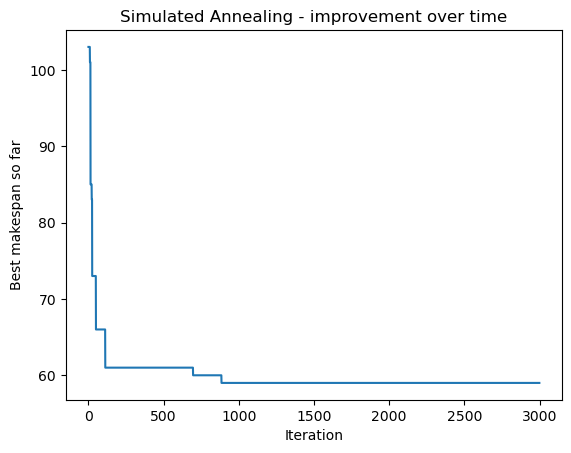

In [275]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best makespan so far")
plt.title("Simulated Annealing - improvement over time")
plt.show()


In [276]:
runs = 10
best_values = []

for r in range(runs):
    # new random start
    sol0 = solution[:] 
    random.shuffle(sol0)

    _, best_ms_run, _ = simulated_annealing(jobs, n_machines, sol0, iters=3000, T0=100.0, alpha=0.995)
    best_values.append(best_ms_run)

print("Best makespan per run:", best_values)
print("Min:", min(best_values), "Mean:", sum(best_values)/len(best_values))


iter 0 current_ms 112 best_ms 112
iter 1 current_ms 112 best_ms 112
iter 2 current_ms 112 best_ms 112
iter 3 current_ms 106 best_ms 106
iter 4 current_ms 106 best_ms 106
iter 5 current_ms 103 best_ms 103
iter 6 current_ms 99 best_ms 99
iter 7 current_ms 99 best_ms 99
iter 8 current_ms 99 best_ms 99
iter 9 current_ms 99 best_ms 99
iter 10 current_ms 94 best_ms 94
iter 11 current_ms 94 best_ms 94
iter 12 current_ms 101 best_ms 94
iter 13 current_ms 110 best_ms 94
iter 14 current_ms 100 best_ms 94
iter 15 current_ms 96 best_ms 94
iter 16 current_ms 96 best_ms 94
iter 17 current_ms 93 best_ms 93
iter 18 current_ms 91 best_ms 91
iter 19 current_ms 91 best_ms 91
iter 20 current_ms 82 best_ms 82
iter 21 current_ms 79 best_ms 79
iter 22 current_ms 97 best_ms 79
iter 23 current_ms 97 best_ms 79
iter 24 current_ms 82 best_ms 79
iter 25 current_ms 82 best_ms 79
iter 26 current_ms 82 best_ms 79
iter 27 current_ms 83 best_ms 79
iter 28 current_ms 83 best_ms 79
iter 29 current_ms 83 best_ms 79
iter 

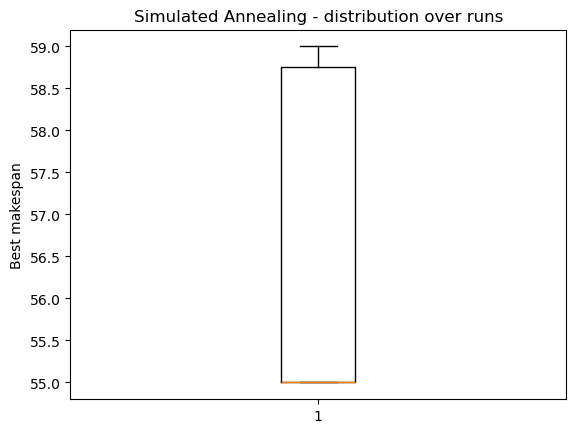

In [277]:
plt.figure()
plt.boxplot(best_values)
plt.ylabel("Best makespan")
plt.title("Simulated Annealing - distribution over runs")
plt.show()
